In [1]:
import scipy.io
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nilearn
import brainspace

from brainspace.gradient import GradientMaps
from brainspace.datasets import load_parcellation
from brainstat.datasets import fetch_parcellation
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import statsmodels

# Loading Data

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/28Me/data/'

resdir = '/data/p_02667/28Me/results/'
resdir_fig = resdir + 'figures/'

In [11]:
path_list = os.listdir(datadir + 'coherence/coherence/28andMe/noGSR/')
path_list.sort()

In [15]:
# looking at correlation matrix

all_corr = []
for file in path_list:
    
    arr = scipy.io.loadmat(datadir + 'coherence/coherence/28andMe/noGSR/'+file)['coherence'][0][0][0][0][0][0][:400,:400]
    
    all_corr.append(arr[:400, :400])
    
all_corr = np.asarray(all_corr)
all_corr_mean = np.sum(all_corr, axis=0)/len(all_corr)
df_mean = pd.DataFrame(all_corr_mean)

In [16]:
df_mean

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.000000,0.545185,0.484409,0.253077,0.186381,0.245315,0.291586,0.311411,0.196569,0.302864,...,0.227061,0.161100,0.140098,0.182467,0.151461,0.140932,0.186737,0.150975,0.144401,0.228192
1,0.545185,0.000000,0.344228,0.343388,0.137568,0.227258,0.314868,0.196411,0.213381,0.359902,...,0.173177,0.119474,0.118398,0.153802,0.138304,0.112121,0.148647,0.135828,0.112769,0.198693
2,0.484409,0.344228,0.000000,0.375376,0.472200,0.424508,0.418097,0.196688,0.312990,0.263784,...,0.251406,0.174949,0.150022,0.199316,0.142448,0.136880,0.173953,0.154201,0.148367,0.233327
3,0.253077,0.343388,0.375376,0.000000,0.279251,0.305656,0.238752,0.119723,0.196994,0.253567,...,0.146104,0.108169,0.111503,0.123502,0.102716,0.095820,0.115444,0.105565,0.102292,0.151931
4,0.186381,0.137568,0.472200,0.279251,0.000000,0.419996,0.231927,0.120614,0.350049,0.140889,...,0.175575,0.127570,0.125660,0.137741,0.111985,0.103014,0.129590,0.114823,0.112453,0.182561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.140932,0.112121,0.136880,0.095820,0.103014,0.099220,0.115232,0.132856,0.107795,0.105136,...,0.277648,0.351893,0.334920,0.210136,0.223740,0.000000,0.338915,0.327205,0.485227,0.123887
396,0.186737,0.148647,0.173953,0.115444,0.129590,0.129000,0.145426,0.187590,0.133554,0.126942,...,0.264768,0.235557,0.371895,0.271637,0.477110,0.338915,0.000000,0.345258,0.373731,0.275254
397,0.150975,0.135828,0.154201,0.105565,0.114823,0.130525,0.132913,0.135698,0.122666,0.135326,...,0.291991,0.239148,0.386827,0.423779,0.349719,0.327205,0.345258,0.000000,0.248823,0.192199
398,0.144401,0.112769,0.148367,0.102292,0.112453,0.103874,0.110349,0.134989,0.105084,0.095523,...,0.255200,0.439880,0.375769,0.235396,0.189123,0.485227,0.373731,0.248823,0.000000,0.179024


In [6]:
hormones = pd.read_excel(datadir+'28Hormones_LP_3_30_20.xlsx')

hormones_28Me = hormones[hormones['Experiment'] == '28andMe']
hormones_28Me = hormones_28Me.rename(columns={"Estradiol (LCMS; pg/mL)": "estradiol", "Progesterone (LCMS; ng/mL)": "progesterone", "LH (mIU/ml)": "lh", "FSH (mIU/ml)": "fsh"})

## Import functions

In [ ]:
path_list = os.listdir('../coherence/28andMe/hasGSR/')
path_list.sort()

In [ ]:
# deleting last 15 rows and last 15 columns

# nums = []
# for i in range(15):
#     nums.append(400+i)

# df.drop(labels=nums, axis=1, inplace=True)
# df.drop(labels=nums, axis=0, inplace=True)

# arr = df.to_numpy()

In [ ]:
# correlation matrix
plt.matshow(df_mean)
plt.show()

# Calculating and Plotting Gradient Using BrainSpace

In [14]:
# functions for correcting parcellation

# gradient parameter should be a GradientMaps object
def plot_correct_gradient(gradient):
    # create and fit gradient

    ### Transform to fsaverage space for plotting - given that Scahefer 400 17 network parcellation order != Schaefer 400 7 network (used in brainspace plot hemispheres)

    # fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel - seven_networks=False means 17 yeo networks
    schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400, seven_networks=False)

    mean_G1_fs5 = []

    # iterate over the 20484 vertices in fsaverage5
    for i in range(len(schaefer_400_fs5)):

        if schaefer_400_fs5[i] == 0:  # corresponds to the midline
            # append to the lists of fs5_tvals: 0
            mean_G1_fs5.append(0)

        else:
            # append to the lists of fs5_tvals: the value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
            mean_G1_fs5.append(gm.gradients_[:,0][schaefer_400_fs5[i]-1])


    # transform list into array
    mean_G1_fs5 = np.asarray(mean_G1_fs5)

    # change the zeros into nan (couldn't nan directly because then it made the array content strings)
    mean_G1_fs5[mean_G1_fs5 == 0] = np.nan


    print(f"Length of fsaverage5 data: {len(mean_G1_fs5)}")

    ### Plot on hemispheres

    # need to plot right and left hemispheres with fsaverage mesh (instead of loading conte69) because I transformed the data in fsaverage5 (already in format: 20484 vertices) unlike conte69 (64984 vertices)
    mesh_paths = {
       'L': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_left'],
       'R': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_right']
    }
    surf_lh = brainspace.mesh.mesh_io.read_surface(mesh_paths['L'])
    surf_rh = brainspace.mesh.mesh_io.read_surface(mesh_paths['R'])


    plotted_hemispheres = plot_hemispheres(
    surf_lh, 
    surf_rh, 
    array_name = mean_G1_fs5, 
    embed_nb = True, 
    size = (1400,200), 
    cmap = 'viridis_r', 
    color_bar = True, 
    #color_range = color_range_t,
    nan_color = (0.7, 0.7, 0.7, 1),
    #label_text = [""],
    zoom = 1.45)

    plotted_hemispheres
    
def correct_corr_to_arr(corr):
    
    gm = GradientMaps(n_components=10, random_state=0)
    gm.fit(corr)
    
    # create and fit gradient

    ### Transform to fsaverage space for plotting - given that Scahefer 400 17 network parcellation order != Schaefer 400 7 network (used in brainspace plot hemispheres)

    # fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel - seven_networks=False means 17 yeo networks
    schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400, seven_networks=False)

    correct_arr = []

    # iterate over the 20484 vertices in fsaverage5
    for i in range(len(schaefer_400_fs5)):

        if schaefer_400_fs5[i] == 0:  # corresponds to the midline
            # append to the lists of fs5_tvals: 0
            correct_arr.append(0)

        else:
            # append to the lists of fs5_tvals: the value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
            correct_arr.append(gm.gradients_[:,0][schaefer_400_fs5[i]-1])


    # transform list into array
    correct_arr = np.asarray(correct_arr)

    # change the zeros into nan (couldn't nan directly because then it made the array content strings)
    correct_arr[correct_arr == 0] = np.nan

    return correct_arr

def correct_arr_to_20484(arr):


    ### Transform to fsaverage space for plotting - given that Scahefer 400 17 network parcellation order != Schaefer 400 7 network (used in brainspace plot hemispheres)

    # fetch the fsaverage parcellation labeling each of fsaverage5's 20484 vertices with its corresponding Schaefer parcel - seven_networks=False means 17 yeo networks
    schaefer_400_fs5 = fetch_parcellation("fsaverage5", "schaefer", 400, seven_networks=False)

    correct_arr = []

    # iterate over the 20484 vertices in fsaverage5
    for i in range(len(schaefer_400_fs5)):

        if schaefer_400_fs5[i] == 0:  # corresponds to the midline
            # append to the lists of fs5_tvals: 0
            correct_arr.append(0)

        else:
            # append to the lists of fs5_tvals: the value of the corresponding Schaefer parcel (here parcel value [i] - 1 because parcel numbers go from 1-400 instead of 0-399 as required for indexing)
            correct_arr.append(arr[schaefer_400_fs5[i]-1])


    # transform list into array
    correct_arr = np.asarray(correct_arr)

    # change the zeros into nan (couldn't nan directly because then it made the array content strings)
    correct_arr[correct_arr == 0] = np.nan

    return correct_arr

In [17]:
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(all_corr_mean)
gm.gradients_[:,0].shape

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


(400,)

In [18]:
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(all_corr_mean)

plot_correct_gradient(gm)

Length of fsaverage5 data: 20484


/data/u_serio_software/anaconda3/lib/python3.9/site-packages/brainspace/plotting/base.py:292: UserWarning: Support for interactive mode is only provided for a single renderer: 'nrow=1' and 'ncol=1'. Setting 'interactive=False'
  warnings.warn("Support for interactive mode is only provided for "


/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


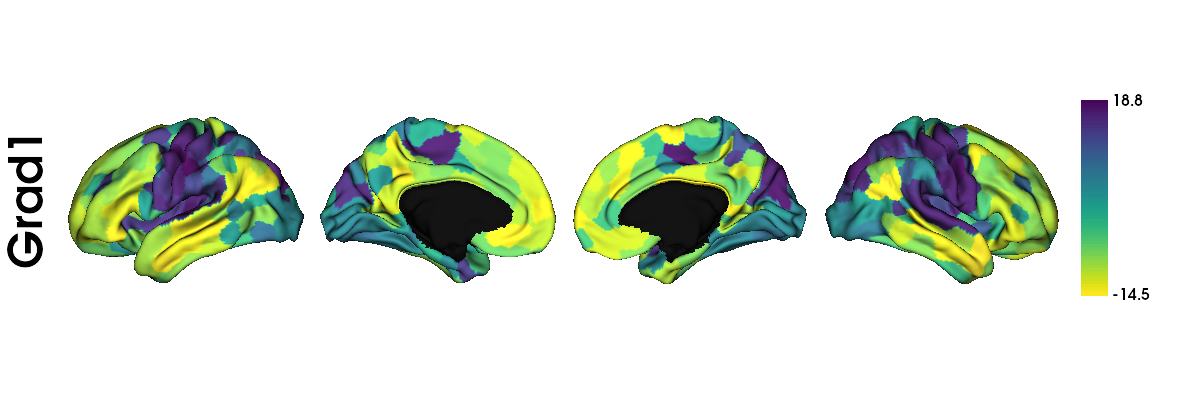

In [29]:
# # OLD CODE WITH INCORRECT PARCELLATION

# # create and fit gradient
# gm = GradientMaps(n_components=10, random_state=0)
# gm.fit(all_corr_mean)

# labeling = load_parcellation('schaefer', scale=400, join=True)
# surf_lh, surf_rh = load_conte69()

# mask = labeling != 0

# # map the gradient to the parcels
# grad = map_to_labels(gm.gradients_[:,0], labeling, mask=mask, fill=np.nan)

# plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1200, 400), cmap='viridis_r',
#                  color_bar=True, label_text=['Grad1'], zoom=1.2, embed_nb=True)

# Hormone Analysis

In [5]:
pd.read_csv('../28Hormones_LP_3_30_20.csv')

,Experiment,ExperimentDay,OpenNeuroSessionID,Estradiol (LCMS; pg/mL),Progesterone (LCMS; ng/mL),LH (mIU/ml),FSH (mIU/ml),CycleNotes
0,28andMe,1,1,52.40,11.900,8.61,5.06,NaN
1,28andMe,2,2,74.20,10.600,4.89,4.13,NaN
2,28andMe,3,3,91.70,12.400,5.98,3.49,NaN
3,28andMe,4,4,94.60,13.500,4.32,3.65,NaN
4,28andMe,5,5,110.00,15.000,3.44,3.30,NaN
5,28andMe,6,6,117.00,15.500,2.58,3.08,NaN
6,28andMe,7,7,125.00,13.300,3.55,3.26,NaN
7,28andMe,8,8,123.00,8.780,5.21,4.47,NaN
8,28andMe,9,9,109.00,6.050,4.76,4.76,NaN
9,28andMe,10,10,73.80,2.460,3.32,7.94,NaN


In [19]:
hormones = pd.read_excel(datadir+'28Hormones_LP_3_30_20.xlsx')[:30]

estrogen = hormones['Estradiol (LCMS; pg/mL)'].to_numpy()
progesterone = hormones['Progesterone (LCMS; ng/mL)'].to_numpy()
experiment = hormones['Experiment'].to_numpy()
time = hormones['ExperimentDay'].to_numpy()
lh = hormones['LH (mIU/ml)'].to_numpy()
fsh = hormones['FSH (mIU/ml)'].to_numpy()

In [20]:
np.isnan(estrogen).any()

False

In [57]:
# # NEW PARCELLATION

# gref = GradientMaps(n_components=10, random_state=0)
# gref.fit(all_corr_mean)

# # get correlation matrices for all 30 days, align them to mean gradient, and store all 30 correlation matrices in grad_arr
# grad_arr = []

# for i in range(len(path_list)):
    
#     area_arr = []
    
#     path = '../coherence/28andMe/noGSR/' + path_list[i]
#     mat = scipy.io.loadmat(path)
#     result = mat.items()
#     data = list(result)

#     # data format is weird, this is how to get the actual corr matrix
#     intrm = data[3][1]
#     corr = intrm[0][0][0][0][0][0]
#     corr = corr[:400, :400]
    
#     correct_corr = correct_arr(corr)

# #     galign = GradientMaps(kernel='normalized_angle', approach='le', alignment='procrustes')
# #     galign.fit(corr, reference=gref.gradients_)
    
# #     for i in range(400):
        
# #         area_arr.append(np.transpose(galign.gradients_)[0][i])
        
# #     grad_arr.append(area_arr)

#     grad_arr.append(correct_corr)
    
    
# grad_arr = np.transpose(np.asarray(grad_arr))


/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


In [23]:
path_list

['day-01.mat',
 'day-02.mat',
 'day-03.mat',
 'day-04.mat',
 'day-05.mat',
 'day-06.mat',
 'day-07.mat',
 'day-08.mat',
 'day-09.mat',
 'day-10.mat',
 'day-11.mat',
 'day-12.mat',
 'day-13.mat',
 'day-14.mat',
 'day-15.mat',
 'day-16.mat',
 'day-17.mat',
 'day-18.mat',
 'day-19.mat',
 'day-20.mat',
 'day-21.mat',
 'day-22.mat',
 'day-23.mat',
 'day-24.mat',
 'day-25.mat',
 'day-26.mat',
 'day-27.mat',
 'day-28.mat',
 'day-29.mat',
 'day-30.mat']

In [24]:
datadir

'/data/p_02667/28Me/data/'

In [25]:
# OLD PARCELLATION

gref = GradientMaps(n_components=10, random_state=0)
gref.fit(all_corr_mean)

# get correlation matrices for all 30 days, align them to mean gradient, and store all 30 correlation matrices in grad_arr
grad_arr = []

for i in range(len(path_list)):
    
    area_arr = []
    
    path = datadir+'coherence/coherence/28andMe/noGSR/' + path_list[i]
    mat = scipy.io.loadmat(path)
    result = mat.items()
    data = list(result)

    # data format is weird, this is how to get the actual corr matrix
    intrm = data[3][1]
    corr = intrm[0][0][0][0][0][0]
    corr = corr[:400, :400]
    
#     correct_corr = correct_arr(corr)

    galign = GradientMaps(kernel='normalized_angle', approach='dm', alignment='procrustes')
    galign.fit(corr, reference=gref.gradients_)
    
    for i in range(400):
        
        area_arr.append(np.transpose(galign.aligned_)[0][i])
        
    grad_arr.append(area_arr)

#     grad_arr.append(corr)
    
    
grad_arr = np.transpose(np.asarray(grad_arr))

In [26]:
grad_arr.shape

(400, 30)

## P values, R values, and Q values Calculated for Each Parcel of the Brain

In [59]:
# r_values = []
# p_values = []

# for i in range(len(grad_arr)):
#     # r value
#     slope, intercept, r_value, p_value, std_err = stats.linregress(grad_arr[i], progesterone)
#     r_values.append(r_value)
# #     p_values.append(p_value)
    
#     p_value = ttest_rel(grad_arr[i], progesterone).pvalue
#     p_values.append(p_value)

    
# r_values = np.asarray(r_values)
# p_values = np.asarray(p_values)

In [60]:
# # modifying p_values array to only contain significant p values ( < 0.05) non significant p values are set to NaN

# for i in range(len(p_values)):
#     if(p_values[i] > 0.05):
#         p_values[i] = float('nan')

In [61]:
# count = 0
# for i in range(len(p_values)):
#     if(np.isnan(p_values[i])):
#         count+=1
# print(count)

6796


In [27]:
def q_values(p_values):
    
    # setting up array for calculating q values
    # creates a numpy array all_values: first column is p_value (sorted), second column is rank (the original order of p_values), and third column is q_values
    df = pd.DataFrame(p_values) 
    df['rank'] = np.arange(1, len(p_values)+1)
    df['qvals'] = np.zeros(len(p_values))
    df = df.rename(columns={0: 'pvals'})
    df = df.sort_values('pvals')
    all_values = df.to_numpy()
    
    # algorithm from this youtube video: https://www.youtube.com/watch?v=_I6S-NTGRA4&ab_channel=TianlinHE
    # sort
    # assign each a rank starting from one
    # theoretical q value = p value * number of samples / rank
    # practical q value = min(p value * number of samples / rank, q value of higher term)

    for i in range(len(all_values)):
        
        idx = len(all_values) - i - 1
        
        if(np.isnan(all_values[idx][0])):
            qval = 1
            print("NAN")
            
        else:

            if(idx == len(all_values)-1):
                higher_q = 1

            else:
                higher_q = all_values[idx+1][2]

            qval = min(higher_q, (all_values[idx][0] * len(all_values)) / (idx+1))
        
        all_values[idx][2] = qval
    
    # sorts all_values by rank column to get the array in its original order and returns the q values
    df = pd.DataFrame(all_values)
    print(df)
    df = df.sort_values(1)
    print(df)
    q_values = df.to_numpy()[:, 2]
    
    return q_values
        

In [28]:
mesh_paths = {
   'L': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_left'],
   'R': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_right']
}
surf_lh = brainspace.mesh.mesh_io.read_surface(mesh_paths['L'])
surf_rh = brainspace.mesh.mesh_io.read_surface(mesh_paths['R'])

plot_hemispheres(surf_lh, surf_rh, array_name=p_values, size=(1200, 200), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1'], nan_color = (0.7,0.7,0.7,1), zoom=1.2, embed_nb=True)

NameError: name 'p_values' is not defined

In [52]:
plot_hemispheres(surf_lh, surf_rh, array_name=p_values, size=(1200, 200), cmap='viridis_r',
                 color_bar=True, label_text=['Grad1'], zoom=1.2, embed_nb=True, nan_color = (10,10,10,5))

ValueError: Array shape is not valid.

## Linear Mixed Effects Model

In [29]:
import statsmodels.regression.mixed_linear_model

In [30]:
lmer_res = {'parcel_number' : [], 
                                 't_val estrogen': [],
                                 'p_val estrogen': [], 't_val progesterone': [],
                                 'p_val progesterone': []}

time_data = np.arange(30)
group_data = np.ones(30)

for i in range(400):
    # make a dataframe that will contain the data for linear mixed effects model (only change is the WN dispersion metric (1-7 networks)
#     df = pd.DataFrame({'G1': grad_arr[i], 'estrogen': estrogen, 'progesterone': progesterone,  'time': time_data, 'group': group_data})

#     # define model
#     model = statsmodels.regression.mixed_linear_model.MixedLM.from_formula(
#         formula = "G1 ~ estrogen + progesterone",
#         re_formula= "1",
#         groups= "group",
#         vc_formula={"time": "0 + C(time)"},  # random effect of time
#         data = df)

    model = statsmodels.regression.mixed_linear_model.MixedLM(
        endog = grad_arr[i],
        exog = pd.DataFrame({'estrogen':estrogen, 'progesterone':progesterone}),
        groups = experiment,
        exog_re = time)
        
    # fit model
    results = model.fit()
    results.summary()

    lmer_res['parcel_number'].append(i)
    if(np.isnan(results.tvalues['estrogen'])):
        print("INDEX: ", i, " NAN")
    lmer_res['t_val estrogen'].append(results.tvalues['estrogen'])
    lmer_res['p_val estrogen'].append(results.pvalues['estrogen'])
    
    lmer_res['t_val progesterone'].append(results.tvalues['progesterone'])
    lmer_res['p_val progesterone'].append(results.pvalues['progesterone'])
    
#     lmer_res['t_val progesterone'].append(results.tvalues['progesterone'])
#     lmer_res['p_val progesterone'].append(results.pvalues['progesterone'])

/data/u_serio_software/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/data/u_serio_software/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parame

In [34]:
lmer_res = {'parcel_number' : [], 
                                 't_val estrogen': [],
                                 'p_val estrogen': [], 't_val progesterone': [],
                                 'p_val progesterone': []}

time_data = np.arange(30)
group_data = np.ones(30)

for i in range(400):
    # make a dataframe that will contain the data for linear mixed effects model (only change is the WN dispersion metric (1-7 networks)
#     df = pd.DataFrame({'G1': grad_arr[i], 'estrogen': estrogen, 'progesterone': progesterone,  'time': time_data, 'group': group_data})

#     # define model
#     model = statsmodels.regression.mixed_linear_model.MixedLM.from_formula(
#         formula = "G1 ~ estrogen + progesterone",
#         re_formula= "1",
#         groups= "group",
#         vc_formula={"time": "0 + C(time)"},  # random effect of time
#         data = df)

    model = statsmodels.regression.mixed_linear_model.MixedLM(
        endog = grad_arr[i],
        exog = pd.DataFrame({'estrogen':estrogen, 'progesterone':progesterone}),
        groups = group_data,
        exog_re = time_data)
        
    # fit model
    results = model.fit()
    results.summary()

    lmer_res['parcel_number'].append(i)
    if(np.isnan(results.tvalues['estrogen'])):
        print("INDEX: ", i, " NAN")
        print(results.summary())
        
    lmer_res['t_val estrogen'].append(results.tvalues['estrogen'])
    lmer_res['p_val estrogen'].append(results.pvalues['estrogen'])
    
    lmer_res['t_val progesterone'].append(results.tvalues['progesterone'])
    lmer_res['p_val progesterone'].append(results.pvalues['progesterone'])
    
#     lmer_res['t_val progesterone'].append(results.tvalues['progesterone'])
#     lmer_res['p_val progesterone'].append(results.pvalues['progesterone'])

/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

INDEX:  209  NAN
         Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: y      
No. Observations:   30      Method:             REML   
No. Groups:         1       Scale:              0.0002 
Min. group size:    30      Log-Likelihood:     68.3296
Max. group size:    30      Converged:          Yes    
Mean group size:    30.0                               
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
estrogen      0.000                                    
progesterone -0.000    0.000 -0.828 0.407 -0.001  0.000
x_re1 Var     0.000                                    



/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at t

INDEX:  222  NAN
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y      
No. Observations: 30      Method:             REML   
No. Groups:       1       Scale:              0.0003 
Min. group size:  30      Log-Likelihood:     64.3270
Max. group size:  30      Converged:          Yes    
Mean group size:  30.0                               
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
estrogen     0.000                                   
progesterone 0.000    0.000 0.198 0.843 -0.001  0.001
x_re1 Var    0.000                                   



/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/deniz/miniconda/envs/cng/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the b

In [31]:
estrogen.shape

(30,)

In [32]:
grad_arr.shape

(400, 30)

In [35]:
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
        Mixed Linear Model Regression Results
=====================================================
Model:            MixedLM Dependent Variable: y      
No. Observations: 30      Method:             REML   
No. Groups:       1       Scale:              0.0024 
Min. group size:  30      Log-Likelihood:     33.4875
Max. group size:  30      Converged:          Yes    
Mean group size:  30.0                               
-----------------------------------------------------
             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------
estrogen     0.000    0.000 1.823 0.068 -0.000  0.001
progesterone 0.002    0.001 1.304 0.192 -0.001  0.005
x_re1 Var    0.000    0.001                          
=====================================================

"""

In [33]:
df = pd.DataFrame(lmer_res)

In [34]:
df

,parcel_number,t_val estrogen,p_val estrogen,t_val progesterone,p_val progesterone
0,0,1.292505,0.196182,0.352764,0.724265
1,1,1.876357,0.060606,-0.391531,0.695404
2,2,1.520568,0.128368,0.654852,0.512563
3,3,-0.378818,0.704823,1.422817,0.154789
4,4,-1.079148,0.280522,1.510134,0.131009
...,...,...,...,...,...
395,395,-2.500172,0.012413,-1.652403,0.098452
396,396,-1.539854,0.123596,0.538044,0.590547
397,397,-2.085950,0.036983,-2.265634,0.023474
398,398,-2.194593,0.028193,-1.665606,0.095792


In [35]:
p_values = df['p_val estrogen'].to_numpy()
t_values = df['t_val estrogen'].to_numpy()

In [38]:
t_values

array([ 1.29250502,  1.87635679,  1.52056819, -0.37881756, -1.07914772,
        2.59857585,  2.0716059 ,  2.01584557,  6.19854797,  2.97440561,
        1.17470338,  2.21447719, -0.04050004, -1.10330123,  2.33205261,
       -2.98120631, -2.60267049,  2.27197879,  3.20138708, -0.70624791,
        1.11350286, -2.29142713,  2.84092197, -1.00872366,  0.72863428,
        2.09982899,  4.21547696,  4.81349352,  2.64406834,  0.86791127,
        2.7660498 ,  2.30578729,  1.94184503,  2.17478425,  2.18031189,
        1.89578519,  2.3426479 ,  3.32680716,  2.41989386,  1.84775636,
        2.15790465,  2.16885533,  2.64349025,  2.26335855,  2.69092367,
        2.38260471,  0.86771552,  2.12018667,  2.43263786,  2.02245165,
        1.94920391,  2.04078238,  2.24060716,  2.26470197,  2.15242551,
        2.72048414,  2.8516578 ,  1.92456254,  2.63289998,  0.49518843,
       -1.36060985, -1.76354694,  1.59001199, -0.29775011, -1.34902507,
       -0.1893877 , -2.94456184, -1.35539535, -1.35083233, -0.63

In [42]:
x = np.genfromtxt('lmer_res.estradiol_t_val.csv', delimiter=',')

In [43]:
 x

array([ 1.65562984,  1.05351428,  1.74362165, -1.78287794, -0.90204476,
        1.3004404 ,  4.26446684,  0.99291673,  2.5251869 ,  1.96952588,
        0.81160364,  1.26935184, -0.11190636, -1.62577258,  3.37333041,
       -2.66584394, -3.81209591,  3.47417026,  2.04998089, -0.50928944,
        0.83799314, -3.62611566,  1.60956059, -1.0852856 ,  1.34296868,
        2.37659218,  2.62166883,  5.53294046,  2.89942883,  0.86045189,
        2.59714637,  2.29415044,  1.67021879,  2.08536979,  2.06025129,
        1.81969147,  2.0670143 ,  2.03074132,  3.21976611,  2.02429461,
        3.26663556,  3.66126093,  2.44080515,  2.49342101,  2.27047543,
        5.23685558,  0.96072374,  2.07813164,  1.5331703 ,  4.73346307,
        1.98013715,  2.34194729,  3.70484326,  2.15880995,  2.15966436,
        1.92490796,  1.76846272,  1.93630497,  2.66659827,  0.21164596,
       -2.32921543, -1.55542284,  0.75540788, -0.70039889, -1.03354111,
       -0.3962633 , -1.79012975, -1.54306408, -2.88755872, -0.60

In [17]:
rejected, qvals = statsmodels.stats.multitest.fdrcorrection(p_values)

In [38]:
qvals = q_values(p_values)

            0      1         2
0    0.000041  349.0  0.016462
1    0.000083  142.0  0.016553
2    0.000230  103.0  0.030730
3    0.000734  100.0  0.047059
4    0.000792  307.0  0.047059
..        ...    ...       ...
395  0.939411  279.0  0.947720
396  0.940612  202.0  0.947720
397  0.972146  314.0  0.977032
398  0.982135   13.0  0.984597
399  0.992802  113.0  0.992802

[400 rows x 3 columns]
            0      1         2
387  0.858537    1.0  0.885090
343  0.487986    2.0  0.567426
357  0.638185    3.0  0.713056
290  0.222417    4.0  0.305728
271  0.153012    5.0  0.225018
..        ...    ...       ...
232  0.083470  396.0  0.143144
360  0.660351  397.0  0.731691
132  0.022112  398.0  0.065895
230  0.082207  399.0  0.142100
276  0.166152  400.0  0.239931

[400 rows x 3 columns]


In [39]:
qvals

array([0.88509004, 0.56742608, 0.71305576, 0.30572775, 0.22501836,
       0.65156086, 0.92323421, 0.51290798, 0.33400911, 0.61787322,
       0.87011638, 0.92323421, 0.98459688, 0.05398699, 0.77574421,
       0.45182772, 0.37252622, 0.92323421, 0.62492171, 0.13722294,
       0.342204  , 0.0974246 , 0.86490071, 0.47156742, 0.24916358,
       0.05441649, 0.11499433, 0.15325222, 0.1173604 , 0.27282273,
       0.20336398, 0.04910019, 0.10345434, 0.08613075, 0.0647459 ,
       0.04910019, 0.08152981, 0.26253828, 0.31939732, 0.04705897,
       0.08143719, 0.08794798, 0.4686876 , 0.07982986, 0.06357169,
       0.35265671, 0.04910019, 0.33114007, 0.05604937, 0.07421284,
       0.0574694 , 0.07055201, 0.05435861, 0.04910019, 0.21560117,
       0.12223123, 0.24223008, 0.05779996, 0.13722294, 0.35265671,
       0.86685683, 0.80190682, 0.1848256 , 0.65156086, 0.75658505,
       0.55685028, 0.05007358, 0.06357169, 0.05007358, 0.04910019,
       0.07952748, 0.43095336, 0.04705897, 0.15244523, 0.13006

In [52]:
# nans where q values aren't significant, t values where q values are significant
values_to_plot = []

for i in range(len(qvals)):
    if (qvals[i] > 0.05):
        values_to_plot.append(float('nan'))
        
    else:
        values_to_plot.append(t_values[i])
        

In [41]:
len(values_to_plot)

400

In [49]:
qvals_new = correct_arr_to_20484(qvals)

In [42]:
pvals_new = correct_arr_to_20484(p_values)

In [43]:
tvals_new = correct_arr_to_20484(t_values)

In [53]:
new_values_to_plot = correct_arr_to_20484(values_to_plot)

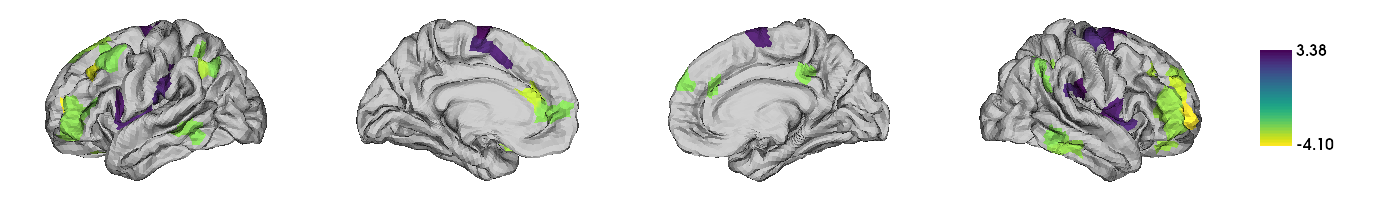

In [54]:
### Plot on hemispheres

# need to plot right and left hemispheres with fsaverage mesh (instead of loading conte69) because I transformed the data in fsaverage5 (already in format: 20484 vertices) unlike conte69 (64984 vertices)
mesh_paths = {
   'L': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_left'],
   'R': nilearn.datasets.fetch_surf_fsaverage('fsaverage5')['pial_right']
}
surf_lh = brainspace.mesh.mesh_io.read_surface(mesh_paths['L'])
surf_rh = brainspace.mesh.mesh_io.read_surface(mesh_paths['R'])


plotted_hemispheres = plot_hemispheres(
surf_lh, 
surf_rh, 
array_name = new_values_to_plot, 
embed_nb = True, 
size = (1400,200), 
cmap = 'viridis_r', 
color_bar = True, 
#color_range = color_range_t,
nan_color = (0.7, 0.7, 0.7, 1),
#label_text = [""],
zoom = 1.45)

plotted_hemispheres
    